In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Exponentiation, ConstantKernel
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from common import detpep10exp, load_detpep10exp_dataset, plot_init

## Analyze different kernels

In [2]:
# Plot setup
plot_init()

# Load dataset
X, y = load_detpep10exp_dataset(n_samples=20, sample_range=(0.01, 1))
print(X.shape)
print(y.shape)

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=43
)

# Dict to save results
scores = {}

(8000, 3)
(8000,)


### Constant kernel

In [3]:
constant_scores = []
for cv in [0.2, 0.5, 1., 1.5, 2.0]:
    # Initialize kernel
    kernel = ConstantKernel(cv, constant_value_bounds='fixed')
    # Train
    gpr = GaussianProcessRegressor(kernel=kernel)
    gpr.fit(X_train, y_train)
    # Evaluate
    score = gpr.score(X_test, y_test)
    print('R2 for constant value {}: {}'.format(cv, score))
    constant_scores.append(score)

R2 for constant value 0.2: -0.002566715658385066
R2 for constant value 0.5: -0.0025972467111756714
R2 for constant value 1.0: -0.0025594321911566187
R2 for constant value 1.5: -0.0025903507181339602
R2 for constant value 2.0: -0.0027017866476179986


### Radial basis function (RBF) kernel

In [4]:
rbf_scores = []
for ls in [0.2, 0.5, 1., 1.5, 2.5]:
    # Initialize kernel
    kernel = RBF(length_scale=ls, length_scale_bounds='fixed')
    # Train
    gpr = GaussianProcessRegressor(kernel=kernel)
    gpr.fit(X_train, y_train)
    # Evaluate
    score = gpr.score(X_test, y_test)
    print('R2 for length scale {}: {}'.format(ls, score))
    rbf_scores.append(score)

R2 for length scale 0.2: 0.999999999668633
R2 for length scale 0.5: 0.9999999532382238
R2 for length scale 1.0: 0.9999976205905474
R2 for length scale 1.5: 0.9999811435831144
R2 for length scale 2.5: 0.9999393208773327


### White kernel

In [5]:
white_scores = []
for nl in [0.2, 0.5, 1., 1.5, 2.5]:
    # Initialize kernel
    kernel = WhiteKernel(noise_level=nl, noise_level_bounds='fixed')
    # Train
    gpr = GaussianProcessRegressor(kernel=kernel)
    gpr.fit(X_train, y_train)
    # Evaluate
    score = gpr.score(X_test, y_test)
    print('R2 for noise level {}: {}'.format(nl, score))
    white_scores.append(score)

R2 for noise level 0.2: -1.6344611652234473
R2 for noise level 0.5: -1.6344611652234473
R2 for noise level 1.0: -1.6344611652234473
R2 for noise level 1.5: -1.6344611652234473
R2 for noise level 2.5: -1.6344611652234473


### Dot product

In [6]:
dot_scores = []
for sigma in [0.2, 0.5, 1., 1.5, 2.5]:
    # Initialize kernel
    kernel = DotProduct(sigma_0=sigma, sigma_0_bounds='fixed')
    # Train
    gpr = GaussianProcessRegressor(kernel=kernel)
    gpr.fit(X_train, y_train)
    # Evaluate
    score = gpr.score(X_test, y_test)
    print('R2 for sigma {}: {}'.format(sigma, score))
    dot_scores.append(score)

R2 for sigma 0.2: 0.734474674675607
R2 for sigma 0.5: 0.7344432631151867
R2 for sigma 1.0: 0.7344460505433748
R2 for sigma 1.5: 0.7345305902383034
R2 for sigma 2.5: 0.734581843890348


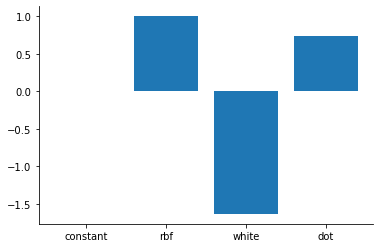

In [7]:
fig, ax = plt.subplots()
ax.bar(['constant', 'rbf', 'white', 'dot'], [max(constant_scores), max(rbf_scores), max(white_scores), max(dot_scores)])
plt.show()